In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.keras.layers import Input, Embedding, LayerNormalization, concatenate, LSTM, BatchNormalization, Dense, Reshape
from tensorflow.python.keras.saving import saving_utils
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Nadam
from sklearn.utils import shuffle
from itertools import product

import scipy as sp
import pandas as pd
import numpy as np

import os, sys
import datetime
import json
import dill as pickle #более мощная библиотека позволяющая сохранять функции
import random
import copy

from IPython.display import display

from scipy.stats import kstest, anderson #lilliefors

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, r2_score, roc_auc_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter("ignore")

%matplotlib inline
pd.set_option('display.max_columns', None)

now_str = lambda : datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

### PARAMETERS

In [2]:
PATH_TO_DATA = '/opt/exchange/PROJECTS/BCG_GAMMA/(data)/'

date_data_start = '2019-01-01 07:00:00'
date_data_finish = '2021-03-31'

date_train_start = '2019-01-01'
date_train_finish = '2021-01-01'

date_valid_start = '2019-01-01'
date_valid_finish = '2021-04-01'

df_filename = 'icl_train.csv'
feat_filename = 'features.csv'

random_state = 42

max_seq_len = 90 * 24 # retrospective steps review

# Seqenced data LSTM model preparation dictionary
data_dict = {'TARGET_NAME':'qty',
             'RNN_NUM_FEAT':['time_of_the_day', 'lune_phase', 'school_holiday', 'max_temp', 'min_temp', 'precipitation', 'days_off', 'qty'],
             'RNN_CAT_FEAT':['weekday', 'day_month', 'week', 'month', 'hour_day'],
             'DIR_NUM_FEAT':['time_of_the_day', 'lune_phase', 'school_holiday', 'max_temp', 'min_temp', 'precipitation', 'days_off'],
             'DIR_CAT_FEAT':['weekday', 'day_month', 'week', 'month', 'hour_day', 'zone', 'reason'], # reason must be last feature in the list
             'CAT':[{'NAME':'weekday',   'PROJECTION':3,  'DICT_SIZE':7},
                    {'NAME':'day_month', 'PROJECTION':4,  'DICT_SIZE':32},
                    {'NAME':'week',      'PROJECTION':8,  'DICT_SIZE':54},
                    {'NAME':'month',     'PROJECTION':4,  'DICT_SIZE':13},
                    {'NAME':'hour_day',  'PROJECTION':6,  'DICT_SIZE':24},
                    {'NAME':'zone',      'PROJECTION':9,  'DICT_SIZE':6},
                    {'NAME':'reason',    'PROJECTION':10, 'DICT_SIZE':10}]}

reason_dict = {0: 'Перевозка плановая',
               1: 'Перевозка экстренная',
               2: 'без сознания',
               3: 'боли в животе',
               4: 'выс. давление( боли в сердце)',
               5: 'выс. давление( голов.боль,головокруж)',
               6: 'выс. темп.',
               7: 'задыхается',
               8: 'плохо',
               9: 'плохо с сердцем'}

zone_dict ={0: 'П/станция 1',
            1: 'П/станция 2',
            2: 'П/станция 3',
            3: 'П/станция 6',
            4: 'П/станция 8',
            5: 'П/станция 9'}

In [3]:
%%time
# DATA LOADING AND PREPROCESSING

df_flat=pd.concat([pd.DataFrame(data={'date':pd.date_range(start=date_data_start, end=date_data_finish, freq='H'), 'zone':zone}) for zone in range(6)], axis=0)

df_feat = pd.read_csv(f'{PATH_TO_DATA}{feat_filename}', index_col=0)

# Data transformation df_feat
mapper={'Максимальная температура, С':'max_temp',
        'Минимальная температура, С':'min_temp',
        'Осадки, часы':'precipitation'}

df_feat.rename(columns=mapper, inplace=True)
df_feat['date'] = pd.to_datetime(df_feat['date'], format='%Y-%m-%d %H:%M:%S')

# Merging with df_feat
cols = ['weekday', 'day_month', 'week', 'month', 'hour_day', 'time_of_the_day', 'lune_phase', 'school_holiday', 'max_temp', 'min_temp', 'precipitation', 'days_off']
int_cols = ['weekday', 'day_month', 'week', 'month', 'hour_day', 'time_of_the_day', 'school_holiday', 'max_temp', 'min_temp', 'precipitation', 'days_off']

for col in cols:
    df_flat[col] = df_flat['date'].map(df_feat.set_index('date')[col])
for col in int_cols:
    df_flat[col] = df_flat[col].fillna(0).astype('int8')

# DF_start processing
df_start=pd.read_csv(f'{PATH_TO_DATA}{df_filename}')
df_start = df_start[['date', 'zone'] + list([reason_dict[key] for key in reason_dict.keys()])]
df_start = df_start[df_start['zone'].isin([zone_dict[key] for key in zone_dict.keys()])]
df_start['zone'] = df_start['zone'].map({zone_dict[key]:key for key in zone_dict.keys()})
df_start.rename(columns={reason_dict[key]:key for key in reason_dict.keys()}, inplace=True)
df_start['date'] = pd.to_datetime(df_start['date'], format='%Y-%m-%d %H:%M:%S')
    
# Merging with df_start
df_flat = pd.merge(left=df_flat,
                   right=df_start,
                   how='left',
                   on=['date', 'zone'])
df_flat.loc[:,'zone':] = df_flat.loc[:,'zone':].fillna(-1).astype('int8')

del(df_feat, df_start)

CPU times: user 1.71 s, sys: 253 ms, total: 1.97 s
Wall time: 1.97 s


In [4]:
%%time
# df and df_ preparartion
feat_lst = data_dict['DIR_NUM_FEAT'] + data_dict['DIR_CAT_FEAT']
df_lst = []

for col in reason_dict.keys():
    df_lst.append(df_flat[['date'] + feat_lst[:-1]])
    df_lst[-1][data_dict['TARGET_NAME']] = df_flat[col]
    df_lst[-1]['reason'] = col
    df_lst[-1]['reason'] = df_lst[-1]['reason'].astype('int16')
df = pd.concat(df_lst, axis=0)[['date'] + feat_lst + [data_dict['TARGET_NAME']]].reset_index()
df.rename(columns={'index':'index_flat'}, inplace=True)

del(df_lst)

# forming df for training

df_ = df[df['date'] > df_flat['date'].drop_duplicates().sort_values().iloc[max_seq_len]]
df_ = df_.reset_index()

# Converting numeric features to lists
for col in data_dict['RNN_NUM_FEAT']:
    df[col] = df[col].map(lambda x:[x])

CPU times: user 6.42 s, sys: 484 ms, total: 6.9 s
Wall time: 6.9 s


In [5]:
df_

,index,index_flat,date,time_of_the_day,lune_phase,school_holiday,max_temp,min_temp,precipitation,days_off,weekday,day_month,week,month,hour_day,zone,reason,qty
0,2161,2161,2019-04-01 08:00:00,1,0,0,5,-1,0,0,0,1,14,4,8,0,0,1
1,2162,2162,2019-04-01 09:00:00,1,0,0,5,-1,0,0,0,1,14,4,9,0,0,2
2,2163,2163,2019-04-01 10:00:00,1,0,0,5,-1,0,0,0,1,14,4,10,0,0,2
3,2164,2164,2019-04-01 11:00:00,1,0,0,5,-1,0,0,0,1,14,4,11,0,0,1
4,2165,2165,2019-04-01 12:00:00,1,0,0,5,-1,0,0,0,1,14,4,12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050775,1180435,118039,2021-03-30 20:00:00,0,0,0,6,-4,0,0,1,30,13,3,20,5,9,-1
1050776,1180436,118040,2021-03-30 21:00:00,0,0,0,6,-4,0,0,1,30,13,3,21,5,9,-1
1050777,1180437,118041,2021-03-30 22:00:00,0,0,0,6,-4,0,0,1,30,13,3,22,5,9,-1
1050778,1180438,118042,2021-03-30 23:00:00,0,0,0,6,-4,0,0,1,30,13,3,23,5,9,-1


In [6]:
df_['qty'] = (df_['qty'] > 0).astype('int8')

In [3]:
## Model build

# Hotfix function
# patch for keras.model to make it picklable
def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():
    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))
    cls = Model
    cls.__reduce__ = __reduce__
# Run the function
make_keras_picklable()

optimizer =  Nadam(lr=1e-3)    
lstm_units = 32
final_dense_units = 256
random_state = 42

np.random.seed(random_state)
set_seed(random_state)

if not optimizer:
    optimizer = Nadam(lr=1e-3)

inputs = []
seq_layers = []
flat_layers = []
emb_layers_dict = {}

for col in data_dict['CAT']:
    emb_layers_dict[col['NAME']] = Embedding(input_dim=col['DICT_SIZE'],
                                               output_dim=col['PROJECTION'],
                                               trainable=True,
                                               mask_zero=False,
                                               name=f"EMB_{col['NAME']}")


# Sequence Numeric features layer
for col in data_dict['RNN_NUM_FEAT']:
    inputs.append(Input(shape=(None, 1,), dtype='float32', name=f"SEQ_{col}"))

if len (data_dict['RNN_NUM_FEAT']) > 1:
    concat_layer = concatenate(inputs[-len(data_dict['RNN_NUM_FEAT']):], name=f'SEQ_NUM_CONCAT', axis=2)            
    num_norm_layer = BatchNormalization()(concat_layer)
    seq_layers.append(num_norm_layer)

if len (data_dict['RNN_NUM_FEAT']) == 1:
    num_norm_layer = BatchNormalization()(inputs[-1])
    seq_layers.append(num_norm_layer)

# Sequence Categorical features layers
for col in data_dict['RNN_CAT_FEAT']:
    inputs.append(Input(shape=(None, ), dtype='uint32', name=f"SEQ_{col}"))
    emb = emb_layers_dict[col](inputs[-1])
    seq_layers.append(LayerNormalization()(emb))

# All sequence layers concatinating to generate input layer to RNN
concat_layer = concatenate(seq_layers, name=f'SEQ_CONCAT', axis=2)

# RNN layers
lstm = LSTM(units=lstm_units, go_backwards=False, name=f'SEQ_LSTM', return_sequences=False)(concat_layer)
flat_layers.append(lstm)

# Direct Numeric features layer
for col in data_dict['DIR_NUM_FEAT']:
    inputs.append(Input(shape=(1,), dtype='float32', name=col))
    num_norm_layer = BatchNormalization()(inputs[-1])
    flat_layers.append(num_norm_layer)

# Sequence Categorical features layers
for col in data_dict['DIR_CAT_FEAT']:
    inputs.append(Input(shape=(), dtype='uint32', name=col))
    emb = emb_layers_dict[col](inputs[-1])

    reshape = Reshape(([feat['PROJECTION'] for feat in data_dict['CAT'] if feat['NAME']==col][0], ))(emb)
    flat_layers.append(LayerNormalization()(reshape))

# Concatinating of all sequence layers to generate input layer to RNN
final_concat = concatenate(flat_layers, name=f'FINAL_CONCAT', axis=1)
final_dense = Dense(final_dense_units, activation='relu', name='DENSE')(final_concat)

target_qty = Dense(1, activation=None, name='TARGET_QTY')(final_dense)
proba = Dense(1, activation='sigmoid', name='PROBA')(final_dense)

regr_model = Model(inputs=inputs, outputs=target_qty, name='regression_model')
prob_model = Model(inputs=inputs, outputs=proba, name='probability_model')

regr_model.compile(loss='MAE', optimizer=optimizer)
prob_model.compile(loss='binary_crossentropy', optimizer=optimizer)

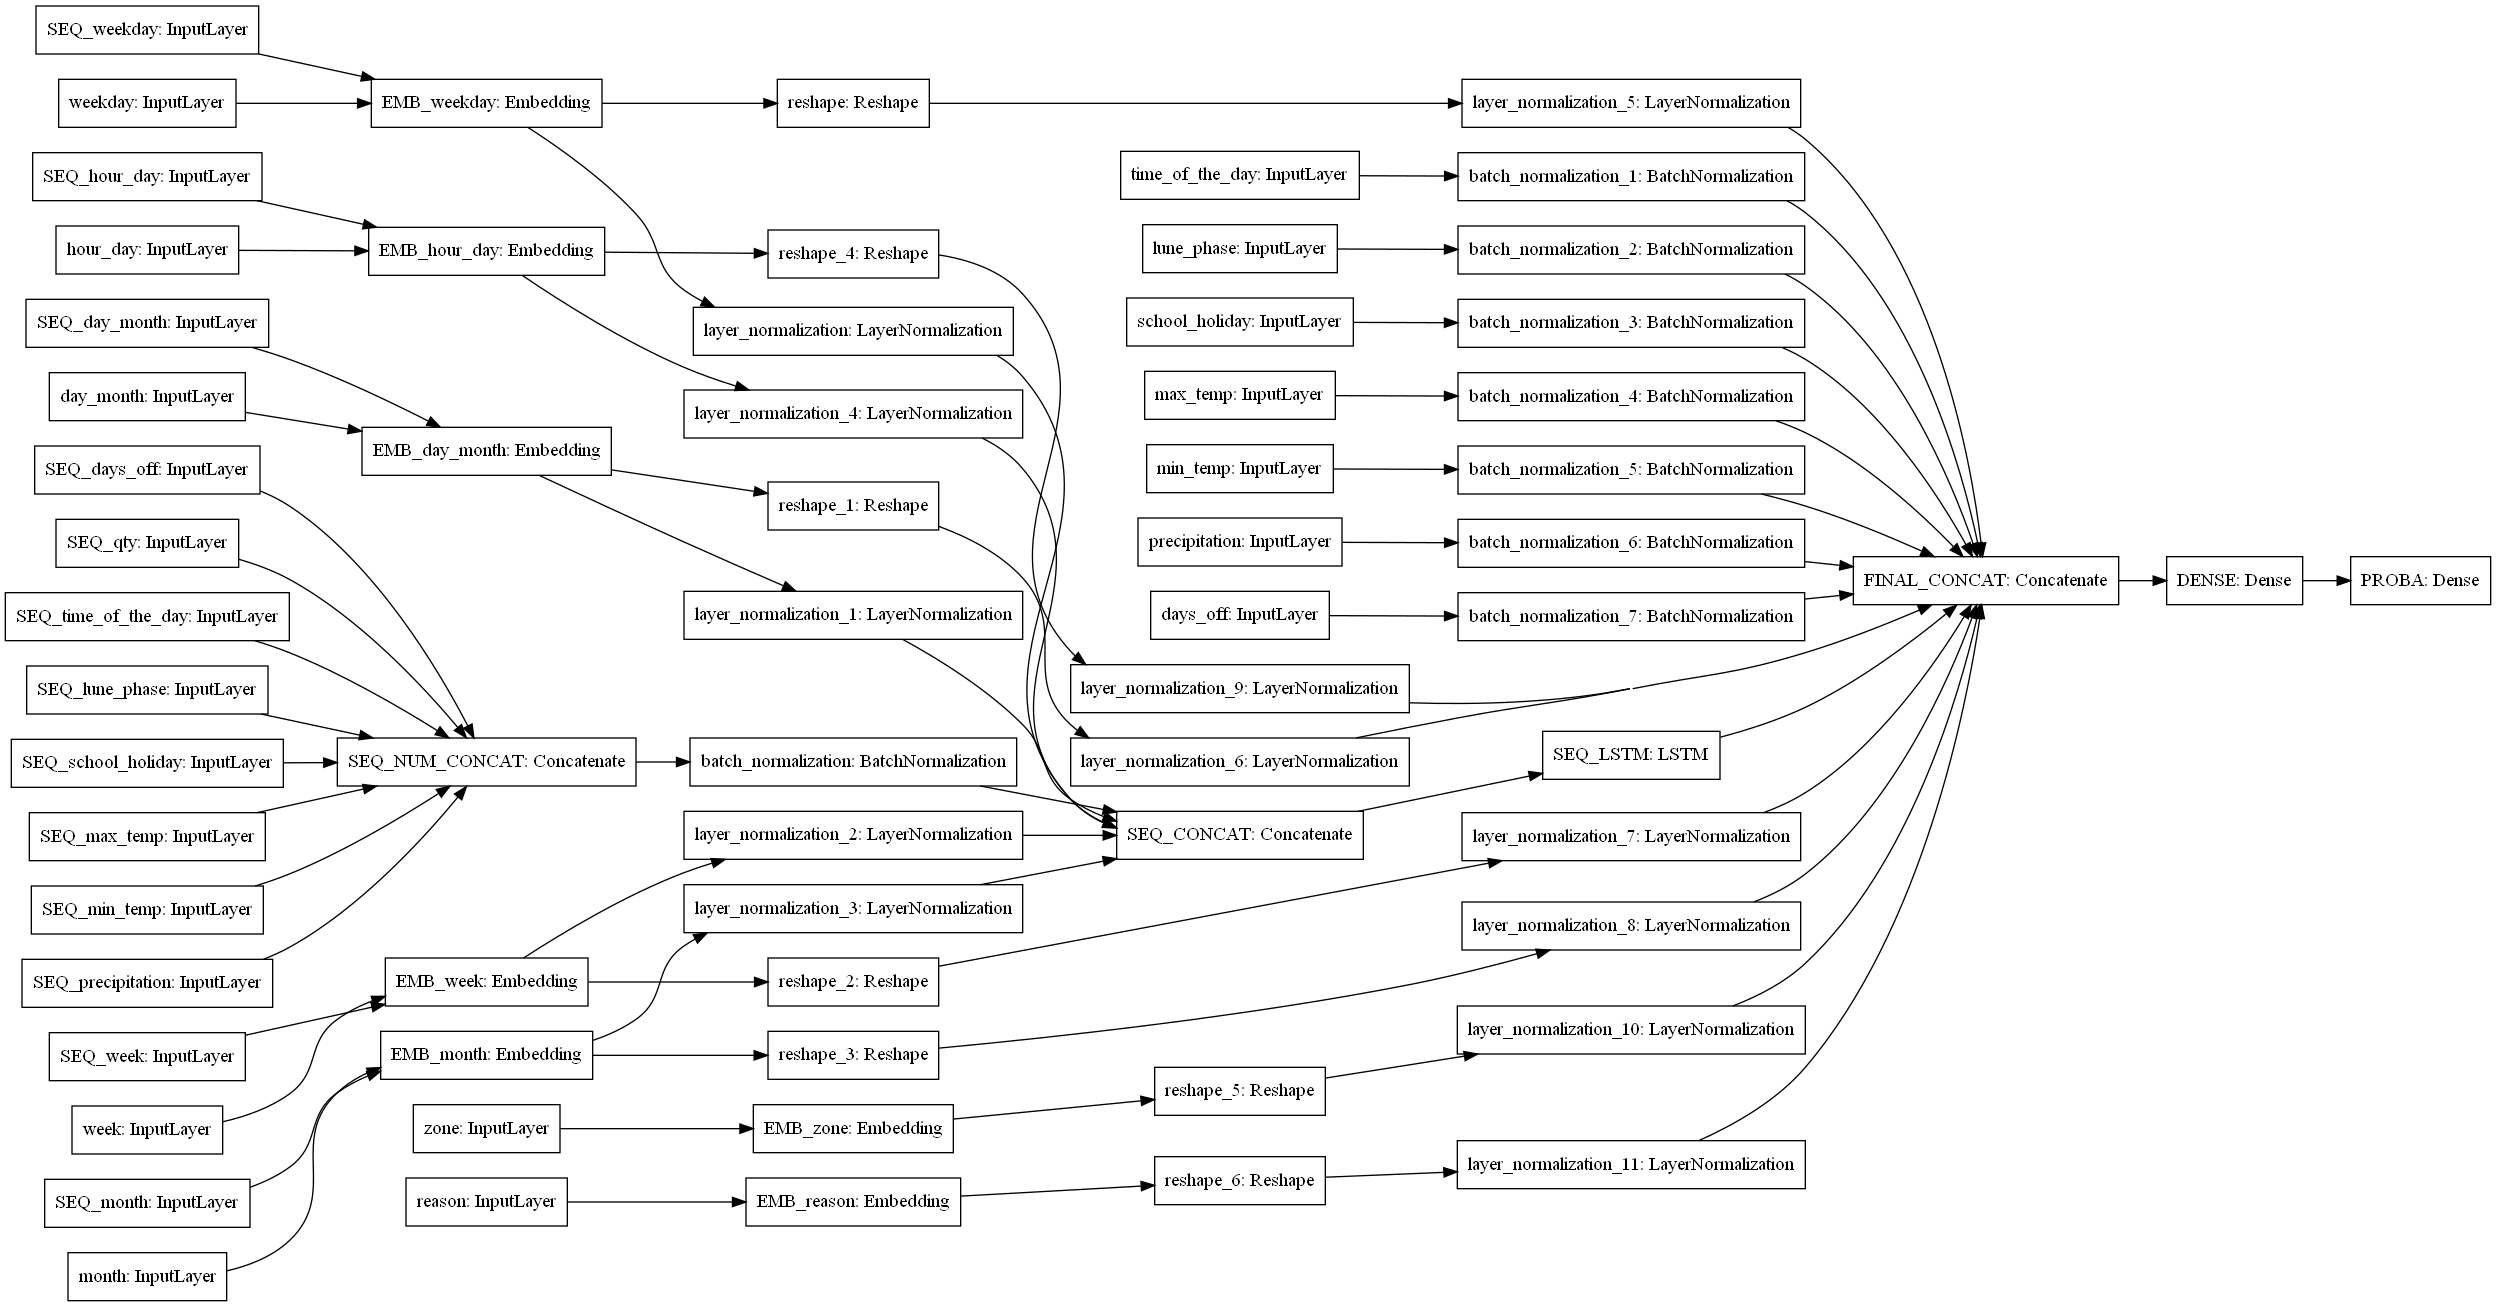

In [4]:
tf.keras.utils.plot_model(prob_model,rankdir='LR')

In [8]:
# batch generation
class BatchGenerator:
    """
    Docstring
    """
    def __init__(self,
                 df=None, # Historical data
                 df_=None, # data to for training or prediction
                 batch_size=32,
                 seq_len = None,
                 order_col='date',
                 data_dict=None,
                 random_state=42):
        """
        Docstring
        """
        self.df = df
        self.df_ = df_
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.random_state = random_state
        self.data_dict = data_dict
        self.steps = (df_.shape[0] // batch_size) if ((df_.shape[0] % batch_size) == 0) else ((df_.shape[0] // batch_size) + 1)

    def gen(self, infinit_mode=False, train_mode=False):

        rnn_feat = data_dict['RNN_NUM_FEAT'] + data_dict['RNN_CAT_FEAT']
        dir_feat = data_dict['DIR_NUM_FEAT'] + data_dict['DIR_CAT_FEAT']
        
        # main cycle
        while True:
            np.random.seed(self.random_state)
            
            if train_mode:
                df_ = self.df_.sample(n=self.df_.shape[0], random_state=self.random_state)

            #df_['batch_num'] = (np.ones((batch_size, df_flat.shape[0] // 32 +1)) * np.arange(df_flat.shape[0] // 32 +1)).astype(int).T.flatten()[:df_flat.shape[0]]

            # Batch generation
            for i in range(self.steps):
                batch_data = []
                for j in range(self.batch_size):
                    ind = self.df_.iloc[i * self.batch_size + j, 0]
                    reason = self.df_.iloc[i * self.batch_size + j]['reason']
                    batch_data.append([self.df.loc[ind - self.seq_len: ind - 1, ['zone'] + [col]].groupby(by='zone').agg(list)[col].values.tolist()[0] for col in rnn_feat])
                x = [np.array([row[n] for row in batch_data]) for n in range(len(rnn_feat))] + [self.df_.iloc[i * self.batch_size: (i+1) * self.batch_size][col].values for col in dir_feat]

                if train_mode:
                    y = self.df_.iloc[i * self.batch_size: (i + 1) * self.batch_size][self.data_dict['TARGET_NAME']].values
                    #sample_weight = self.df_.iloc[i * batch_size: (i+1) * batch_size]['sample_weight'].values
                    yield x, y #, sample_weight
                else:
                    yield x
            
            self.random_state += 1

            if not infinit_mode:
                break

In [9]:
# Stage 1 model training
epochs = 1
random_state += 1
np.random.seed(random_state)
set_seed(random_state)

for i in range(epochs):
    epoch_train_gen = BatchGenerator(df=df, # Historical data
                                     df_=df_[df_['date'] < date_train_finish], # data to for training or prediction
                                     batch_size=32,
                                     seq_len=28*24,
                                     order_col='date',
                                     data_dict=data_dict,
                                     random_state=random_state).gen(infinit_mode=False, train_mode=True)

    prob_model.fit(epoch_train_gen,
                   steps_per_epoch=1000,
                   epochs=1,
                   verbose=True,
                   shuffle=False,
                   class_weight=((1 / df_['qty'].astype(int).value_counts(normalize=True)) / (1 / df_['qty'].astype(int).value_counts(normalize=True)).sum()).to_dict())
    del(epoch_train_gen)

1000/1000 [==============================] - 2915s 3s/step - loss: 0.1979


In [10]:
# Stage 1 model training
epochs = 1
random_state += 1
np.random.seed(random_state)
set_seed(random_state)

for i in range(epochs):
    epoch_train_gen = BatchGenerator(df=df, # Historical data
                                     df_=df_[df_['date'] < date_train_finish], # data to for training or prediction
                                     batch_size=32,
                                     seq_len=28*24,
                                     order_col='date',
                                     data_dict=data_dict,
                                     random_state=random_state).gen(infinit_mode=False, train_mode=True)

    prob_model.fit(epoch_train_gen,
                   steps_per_epoch=1000,
                   epochs=1,
                   verbose=True,
                   shuffle=False)
    del(epoch_train_gen)

1000/1000 [==============================] - 3034s 3s/step - loss: 0.4997


In [13]:
pickle.dump(prob_model, open('prob_model', 'wb'))

In [14]:
# Stage 1 model training
epochs = 1
random_state += 1
np.random.seed(random_state)
set_seed(random_state)

for i in range(epochs):
    epoch_train_gen = BatchGenerator(df=df, # Historical data
                                     df_=df_[df_['date'] < date_train_finish], # data to for training or prediction
                                     batch_size=32,
                                     seq_len=28*24,
                                     order_col='date',
                                     data_dict=data_dict,
                                     random_state=random_state).gen(infinit_mode=False, train_mode=True)

    prob_model.fit(epoch_train_gen,
                   steps_per_epoch=1000,
                   epochs=1,
                   verbose=True,
                   shuffle=False)
    del(epoch_train_gen)

1000/1000 [==============================] - 2901s 3s/step - loss: 0.4935


In [ ]:
## MultiTarget Two Stage Model

class MTModelDev:
    
    '''
    Docstring
    '''
    
    def __init__(self,
                 train_file_list=[],
                 valid_file_list=[],
                 data_dict=None,
                 random_state=42,
                 separate_training_data=False,
                 stage_1_model_optimizer=None,
                 stage_1_model_lstm_units=32,
                 stage_1_model_final_dense_units=128,
                 stage_1_model_random_state=33,
                 stage_2_model_eval_metric='AUC',
                 stage_2_model_iterations=1000,
                 stage_2_model_SKF_splits=5,
                 stage_2_model_class_weight=None,
                 stage_2_model_random_state=21):
        
        '''
        Docstring
        '''
        self.data_dict = data_dict
        self.TARGET_NAME = data_dict['TARGET_NAME']
        
        self.train_file_list = train_file_list
        self.valid_file_list = valid_file_list
        self.random_state = random_state
        self.separate_training_data = separate_training_data
        
        self.stage_1_model_optimizer = stage_1_model_optimizer
        self.stage_1_model_lstm_units = stage_1_model_lstm_units
        self.stage_1_model_final_dense_units = stage_1_model_final_dense_units
        self.stage_1_model_random_state=stage_1_model_random_state
        self.stage_2_model_eval_metric=stage_2_model_eval_metric
        self.stage_2_model_iterations=stage_2_model_iterations
        self.stage_2_model_SKF_splits=stage_2_model_SKF_splits
        self.stage_2_model_class_weight=stage_2_model_class_weight        
        self.stage_2_model_random_state=stage_2_model_random_state
        
        # Class/Sample weight parameters calculation
        df_weight = pd.concat([pd.read_parquet(file_name, columns=[TARGET_NAME, 'TARGET']) for file_name in train_file_list], axis=0).reset_index(drop=True)
        self.stage_1_model_class_weight = (0.5 / df_weight[self.TARGET_NAME].astype(int).value_counts(normalize=True)).to_dict()
        
        self.target_weight = 1 / df_weight['TARGET'].value_counts(normalize=True) / df_weight['TARGET'].nunique()
        self.true_class_weight = 1 / df_weight.groupby('TARGET')[TARGET_NAME].mean() - 1
        
        if type(self.stage_2_model_class_weight)==type(None):
            self.stage_2_model_class_weight = self.stage_1_model_class_weight
        del(df_weight)
        
        self.stage_1_full_model = None
        self.stage_1_model = None
        self.stage_2_model = None
        
        # patch for keras.model to make it picklable
        def unpack(model, training_config, weights):
            restored_model = deserialize(model)
            if training_config is not None:
                restored_model.compile(
                    **saving_utils.compile_args_from_training_config(
                        training_config
                    )
                )
            restored_model.set_weights(weights)
            return restored_model

        # Hotfix function
        def make_keras_picklable():
            def __reduce__(self):
                model_metadata = saving_utils.model_metadata(self)
                training_config = model_metadata.get("training_config", None)
                model = serialize(self)
                weights = self.get_weights()
                return (unpack, (model, training_config, weights))
            cls = Model
            cls.__reduce__ = __reduce__
        # Run the function
        make_keras_picklable()

        self._stage_1_model_build()
        self._stage_2_model_build()
        
        self.SKF_list = None

        
    # Model training
    def fit(self, stage_1_model_train_epochs=1):
        
        '''
        Docstring
        '''
        train_file_list = shuffle(self.train_file_list, random_state=self.random_state)
        if self.separate_training_data:
            stage_1_model_train_file_list = train_file_list[:len(train_file_list) // 2]
            stage_2_model_train_file_list = train_file_list[len(train_file_list) // 2:]
        else:
            stage_1_model_train_file_list = train_file_list
            stage_2_model_train_file_list = train_file_list           
        
        self._stage_1_model_fit(epochs=stage_1_model_train_epochs, train_file_list=stage_1_model_train_file_list)
        self._stage_2_model_fit(class_weight=self.stage_2_model_class_weight, train_file_list=stage_2_model_train_file_list)
        
        self.random_state += 7
        self.stage_1_model_random_state += 7
        self.stage_2_model_random_state += 7
    
        
    def predict(self,
                input_data=None,
                input_type='file_list',         # 'file_list', 'df', 'json'
                output_type='df',        # 'df', 'json', 'csv'
                output_file_name=None,   # название файла в случае если output_type=='csv'
                prod_mode=True,
                features=False):
        
        '''
        Docstring
        '''
        # Data Generator preparation
        if input_type == 'file_list':
            test_gen = BatchGenerator(file_list=input_data, data_dict=self.data_dict).gen(train_mode=False)
        if input_type == 'df':
            test_gen = BatchGenerator(df=input_data, data_dict=self.data_dict).gen(train_mode=False)
        if input_type == 'json':
            test_gen = BatchGenerator(df=pd.DataFrame(json.loads(input_data)['data']), data_dict=self.data_dict).gen(train_mode=False)

        # Stage 1 model prediction
        test_data = self.stage_1_model.predict(test_gen)
        df_test = pd.DataFrame(data=test_data, columns=self.stage_2_model['model_columns'])
        del(test_gen, test_data)   
  
        
        # Stage 2 model prediction
        df_test['proba'] = 0
        for fold in self.stage_2_model['folds']:
            df_test['proba'] += fold['trained_model'].predict_proba(df_test)[:,1] / len(self.stage_2_model['folds'])
        df_test['score'] = ((1 - df_test['proba']) * 1000).astype(int)
        
        # forming output columns list
        result_cols = ['score']
        
        if input_type == 'json':
            df_test['dataItemId'] = pd.DataFrame(json.loads(input_data)['data'])['dataItemId'].values
            result_cols += ['dataItemId']
        
        if not prod_mode:
            result_cols += ['proba']
        
        if features:
            result_cols += self.stage_2_model['model_columns']
        
        # result output
        df_test = df_test[result_cols]
        
        if output_type == 'df':
            return df_test
        
        if output_type == 'csv':
            df_test.to_csv(output_file_name)
            return ''
            
        if output_type == 'json':
            # converting numpy data types to JSON compatible data types function
            def convert_to_json_type(x):
                if str(type(x))[:-4] == "<class 'numpy.int":
                    x = int(x)
                elif str(type(x))[:-4] == "<class 'numpy.float'>":
                    x = float(x)
                else:
                    x = str(x) 
                return x

            pred_dict = {'version': self.version, 
                         'data': [{col: convert_to_json_type(df_test[col].values[i]) for col in df_test.columns} for i in range(df_test.shape[0])]}

            return json.dumps(pred_dict)
            

    # Building Stage 1 model (Bi Directional LSTM model)
    def _stage_1_model_build(self):
        
        data_dict = self.data_dict
        optimizer = self.stage_1_model_optimizer
        lstm_units = self.stage_1_model_lstm_units
        final_dense_units = self.stage_1_model_final_dense_units
        random_state = self.stage_1_model_random_state
        
        np.random.seed(random_state)
        set_seed(random_state)

        if not optimizer:
            optimizer = Nadam(lr=1e-3)    

        inputs = []
        seq_layers = []
        flat_layers = []
        
        emb_pat = Embedding(input_dim=[col['DICT_SIZE'] for col in data_dict['SEQ']['SEQ']['CAT'] if col['NAME']=='WORST_PAYMT_PAT'][0] + 1,
                           output_dim=[col['PROJECTION'] for col in data_dict['SEQ']['SEQ']['CAT'] if col['NAME']=='WORST_PAYMT_PAT'][0],
                           trainable=True,
                           mask_zero=False,
                           name=f"EMB_PAYMT_PAT")

        emb_mc = Embedding(input_dim=[col['DICT_SIZE'] for col in data_dict['CAT'] if col['NAME']=='MEMBER_CODE'][0] + 1,
                           output_dim=[col['PROJECTION'] for col in data_dict['CAT'] if col['NAME']=='MEMBER_CODE'][0],
                           trainable=True,
                           mask_zero=False,
                           name=f"EMB_MEMBER_CODE")
        
        emb_reg = Embedding(input_dim=[col['DICT_SIZE'] for col in data_dict['CAT'] if col['NAME']=='REGION_PR'][0] + 1,
                            output_dim=[col['PROJECTION'] for col in data_dict['CAT'] if col['NAME']=='REGION_PR'][0],
                            trainable=True,
                            mask_zero=False,
                            name=f"EMB_REGION")

        # Sequence RNN layers
        for i, seq in enumerate(data_dict['SEQ_ORDER']):
            seq_layers.append([])

            # Sequence Categorical features layers
            for col in data_dict['SEQ'][seq]['CAT']:
                inputs.append(Input(shape=(None, ), dtype='uint32', name=f"{seq}_{col['NAME']}"))
                
                emb = Embedding(input_dim=col['DICT_SIZE'] + 1,
                                output_dim=col['PROJECTION'],
                                trainable=True,
                                mask_zero=False,
                                name=f"{seq}_EMB_{col['NAME']}")(inputs[-1])
                
                if col['NAME'] == 'MEMBER_CODE':
                    emb = emb_mc(inputs[-1])
                if col['NAME'] in ['WORST_PAYMT_PAT', 'END_PAYMT_PAT']:
                    emb = emb_pat(inputs[-1])

                seq_layers[i].append(LayerNormalization()(emb))


            # Sequence Numeric features layer
            for col in data_dict['SEQ'][seq]['NUM']:
                inputs.append(Input(shape=(None, 1,), dtype='float32', name=f"{seq}_{col}"))
            concat_layer = concatenate(inputs[-len(data_dict['SEQ'][seq]['NUM']):], name=f'{seq}_NUM_CONCAT', axis=2)            
            num_norm_layer = BatchNormalization()(concat_layer)
            seq_layers[i].append(num_norm_layer)

            # All sequence layers concatinating to generate input layer to RNN
            concat_layer = concatenate(seq_layers[i], name=f'{seq}_CONCAT', axis=2)

            # RNN layers
            lstm_stage_1 = LSTM(units=lstm_units, go_backwards=False, name=f'{seq}_LSTM_1', return_sequences=True, return_state=True)(concat_layer)
            lstm_stage_2 = LSTM(units=lstm_units, go_backwards=False, name=f'{seq}_LSTM_2', return_sequences=True, return_state=True)(lstm_stage_1[0])
            lstm_stage_3 = LSTM(units=lstm_units // 2, go_backwards=False, name=f'{seq}_LSTM_3')(lstm_stage_2[0])
            
            flat_layers.append(lstm_stage_1[1])
            flat_layers.append(lstm_stage_2[1])
            flat_layers.append(lstm_stage_3)       

        # Sequence Categorical features layers
        for col in data_dict['CAT']:
            inputs.append(Input(shape=(), dtype='uint32', name=col['NAME']))
            emb = Embedding(input_dim=col['DICT_SIZE'] + 1,
                                            output_dim=col['PROJECTION'],
                                            trainable=True,
                                            mask_zero=False,
                                            name=f"EMB_{col['NAME']}")(inputs[-1])
            if col['NAME'] == 'MEMBER_CODE':            
                emb = emb_mc(inputs[-1])
            if col['NAME'] in ['REGION_PR', 'REGION_REG']:            
                emb = emb_reg(inputs[-1])


            reshape = Reshape((col['PROJECTION'], ))(emb)
            flat_layers.append(LayerNormalization()(reshape))

        # Sequence Numeric features layer
        for col in data_dict['NUM']:
            inputs.append(Input(shape=(len(data_dict['NUM'])), dtype='float32', name=col))
            num_norm_layer = BatchNormalization()(inputs[-1])
            flat_layers.append(num_norm_layer)

        # Concatinating of all sequence layers to generate input layer to RNN
        final_concat = concatenate(flat_layers, name=f'FINAL_CONCAT', axis=1)
        final_dense = Dense(final_dense_units, activation='relu', name='DENSE')(final_concat)
        proba = Dense(2, activation='softmax', name='PROBA')(final_dense)

        stage_1_full_model = Model(inputs=inputs, outputs=proba, name='stage_1_full_model')
        stage_1_full_model.compile(loss='binary_crossentropy', optimizer=optimizer)

        stage_1_model = Model(inputs=inputs, outputs=final_concat, name='stage_1_model')
        stage_1_model.compile(loss='MSE', optimizer=optimizer)
        
        self.stage_1_full_model = stage_1_full_model        
        self.stage_1_model = stage_1_model
        
    
    # Building Stage 2 model (CatBoost classifier)
    def _stage_2_model_build(self):
        
        stage_2_model = catb.CatBoostClassifier(eval_metric=self.stage_2_model_eval_metric,
                                                silent=True,
                                                iterations=self.stage_2_model_iterations,
                                                random_state=self.stage_2_model_random_state)
        
        self.stage_2_model = {'model_name':'stage_2_model',
                              'model_sample':copy.deepcopy(stage_2_model),
                              'model_columns':None,
                              'feature_importance':None,
                              'folds':[{'fold':i,
                                        'trained_model':None,
                                        'feature_prediction_values_change':None,                                                
                                        'feature_loss_function_change':None,
                                        'feature_interaction_importance':None} for i in range(self.stage_2_model_SKF_splits)]}
        
    
    # Stage 1 model training
    def _stage_1_model_fit(self, train_file_list, epochs=1):
            
        train_gen = BatchGenerator(file_list=train_file_list, data_dict=self.data_dict, random_state=self.stage_1_model_random_state)
        
        random_state = self.stage_1_model_random_state
        class_weight = self.stage_1_model_class_weight
        
        np.random.seed(random_state)
        set_seed(random_state)

        for i in range(epochs):
            # Data generator preparation
            print(now_str(), f'Stage 1 model training epoch {i+1} / {epochs}')
            epoch_train_gen = train_gen.gen(train_mode=True)
            
            self.stage_1_full_model.fit(epoch_train_gen,
                                        steps_per_epoch=train_gen.steps,
                                        epochs=1,
                                        verbose=True,
                                        class_weight=class_weight,
                                        shuffle=False)
            del(epoch_train_gen)
            
            #  OOT validation report                   
            print(f'{now_str()} Epoch {i + 1} / {epochs} validation\n')
            valid_gen = BatchGenerator(file_list=self.valid_file_list, data_dict=self.data_dict).gen(train_mode=False)
            pred = self.stage_1_full_model.predict(valid_gen)
            del(valid_gen)
            
            df = pd.concat([pd.read_parquet(file_name, columns=['TARGET_NAME', self.TARGET_NAME])for file_name in self.valid_file_list], axis=0).reset_index(drop=True)
            df['pred'] = pred[:, 1]
            del(pred)
            short_model_score_report(y_true=df[self.TARGET_NAME],
                                     y_pred_proba=df['pred'],
                                     name= 'Stage 1 Valid OOT',
                                     header=True,
                                     model_type='classification')             
            
            for target in df['TARGET_NAME'].unique():
                segment = (df['TARGET_NAME'] == target)
                short_model_score_report(y_true=df[segment][self.TARGET_NAME],
                                         y_pred_proba=df[segment]['pred'],
                                         name= f'Stage 1 Valid OOT {target}',
                                         header=False,
                                         model_type='classification')
            del(df)
            print()
        # transfer weights to stage_1_model
        for i in range(len(self.stage_1_model.layers)):
            if self.stage_1_full_model.layers[i].name == self.stage_1_model.layers[i].name:
                self.stage_1_model.layers[i].set_weights(self.stage_1_full_model.layers[i].get_weights())
    
    # Stage 2 model training
    def _stage_2_model_fit(self, class_weight, train_file_list):
        
        # in case if method is called directly
        self.stage_2_model_class_weight = class_weight
        
        TARGET_NAME = self.TARGET_NAME
        
        print(now_str(), 'Stage 2 training data preparation...')
        stage_2_train_data_gen = BatchGenerator(file_list=train_file_list, data_dict=self.data_dict).gen(train_mode=False)
        stage_2_train_data = self.stage_1_model.predict(stage_2_train_data_gen)
        df = pd.DataFrame(data=stage_2_train_data, columns=[f'F{i:0>3}' for i in range(stage_2_train_data.shape[1])])
        self.stage_2_model['model_columns'] = list(df.columns)
        df['TARGET_NAME'] = pd.concat([pd.read_parquet(file_name, columns=['TARGET_NAME'])['TARGET_NAME'] for file_name in train_file_list], axis=0).reset_index(drop=True)
        df[TARGET_NAME] = pd.concat([pd.read_parquet(file_name, columns=[TARGET_NAME])[TARGET_NAME].astype(int) for file_name in train_file_list], axis=0).reset_index(drop=True)
        df['weight'] = df[TARGET_NAME].map(class_weight)
        
        del(stage_2_train_data, stage_2_train_data_gen)
        
        print(now_str(), 'Stage 2 OOT data preparation...')
        stage_2_oot_data_gen = BatchGenerator(file_list=self.valid_file_list, data_dict=self.data_dict).gen(train_mode=False)
        stage_2_oot_data = self.stage_1_model.predict(stage_2_oot_data_gen)
        df_oot = pd.DataFrame(data=stage_2_oot_data, columns=[f'F{i:0>3}' for i in range(stage_2_oot_data.shape[1])])
        df_oot['TARGET_NAME'] = pd.concat([pd.read_parquet(file_name, columns=['TARGET_NAME'])['TARGET_NAME'] for file_name in self.valid_file_list], axis=0).reset_index(drop=True)
        df_oot[TARGET_NAME] = pd.concat([pd.read_parquet(file_name, columns=[TARGET_NAME])[TARGET_NAME].astype(int) for file_name in self.valid_file_list], axis=0).reset_index(drop=True)
        del(stage_2_oot_data, stage_2_oot_data_gen)
        
        # Forming SKF indexes for ansambling and crossvalidation
        self._SKF(df=df, n_splits=self.stage_2_model_SKF_splits)
        
        print(now_str(), 'Stage 2 model training\n')
        
        # Making dataset for train results recording
        self.valid_oos_pred = df[['TARGET_NAME', TARGET_NAME]]
        self.valid_oos_pred['proba'] = None
        self.valid_oos_pred['proba'] = self.valid_oos_pred['proba'].astype(float)
        
        self.valid_oot_pred = df_oot[['TARGET_NAME', TARGET_NAME]]
        
        for i, (train_index, valid_index) in enumerate(self.SKF_list):
            
            # Training pool preparation
            X_train = df.loc[train_index].drop(columns=['TARGET_NAME', TARGET_NAME, 'weight'])
            y_train = df.loc[train_index][TARGET_NAME]
            sample_weight = df.loc[train_index]['weight']
            
            catb_train_pool = catb.Pool(data=X_train, label=y_train, weight=sample_weight)
            
            # Validation pool preparation
            X_valid_oos = df.loc[valid_index].drop(columns=['TARGET_NAME', TARGET_NAME, 'weight'])
            y_valid_oos = df.loc[valid_index][TARGET_NAME]
            catb_valid_oos_pool = catb.Pool(data=X_valid_oos, label=y_valid_oos)
            
            model_to_train = copy.deepcopy(self.stage_2_model['model_sample'])
            model_to_train.fit(X=catb_train_pool, eval_set=catb_valid_oos_pool, plot=False, use_best_model=True)

            # Saving trained model for each fold
            self.stage_2_model['folds'][i]['trained_model'] = copy.deepcopy(model_to_train)
            # saving features importance data on validation datasets
            self.stage_2_model['folds'][i]['feature_prediction_values_change'] = model_to_train.get_feature_importance(data=catb_valid_oos_pool)
            self.stage_2_model['folds'][i]['feature_loss_function_change'] = model_to_train.get_feature_importance(type='LossFunctionChange', data=catb_valid_oos_pool)
            self.stage_2_model['folds'][i]['feature_interaction_importance'] = model_to_train.get_feature_importance(type='Interaction', data=catb_valid_oos_pool)

            # wrighting model predictions on validation dataset
            self.valid_oot_pred[f'model_{i}_proba'] = model_to_train.predict_proba(df_oot.drop(columns=['TARGET_NAME', TARGET_NAME]))[:,1]
            
            self.valid_oos_pred[f'model_{i}_proba'] = model_to_train.predict_proba(df.drop(columns=['TARGET_NAME', TARGET_NAME, 'weight']))[:,1]
            self.valid_oos_pred.loc[valid_index, 'proba'] = self.valid_oos_pred.loc[valid_index, f'model_{i}_proba']
            self.valid_oos_pred.loc[valid_index, f'model_{i}_proba'] = None
            
            #  Making report for OOT data
            short_model_score_report(y_true=df_oot[TARGET_NAME],
                                     y_pred_proba=self.valid_oot_pred[f'model_{i}_proba'],
                                     name= f'FOLD {i} Valid OOT',
                                     header=(i == 0),
                                     model_type='classification')
            
            #  Making report for OOS data            
            short_model_score_report(y_true=y_valid_oos,
                                     y_pred_proba=self.valid_oos_pred.loc[valid_index, 'proba'],
                                     name=f'FOLD {i} Valid OOS',
                                     header=False,
                                     model_type='classification')

            #  Making report for train data
            short_model_score_report(y_true=y_train,
                                     y_pred_proba=self.valid_oos_pred.loc[train_index, f'model_{i}_proba'],
                                     name= f'FOLD {i} Train data',
                                     header=False,
                                     model_type='classification')
            
            print()
            del(X_train, y_train, X_valid_oos, y_valid_oos, catb_train_pool, catb_valid_oos_pool)
        
        # Making final report (all folds))

        # Calculation of final scores and probabilities for all models        
        self.valid_oos_pred['train_blend_proba'] = self.valid_oos_pred[[f'model_{i}_proba' for i in range(len(self.SKF_list))]].mean(axis=1)
        self.valid_oot_pred['train_blend_proba'] = self.valid_oot_pred[[f'model_{i}_proba' for i in range(len(self.SKF_list))]].mean(axis=1)
        
        
        #  Making final report for OOT data
        short_model_score_report(y_true=self.valid_oot_pred[TARGET_NAME],
                                 y_pred_proba=self.valid_oot_pred['train_blend_proba'],
                                 name= f'FINAL Valid OOT',
                                 header=True,
                                 model_type='classification')

        #  Making final report for OOS data            
        short_model_score_report(y_true=self.valid_oos_pred[TARGET_NAME], 
                                 y_pred_proba=self.valid_oos_pred['proba'],
                                 name=f'FINAL Valid OOS',
                                 header=False,
                                 model_type='classification')

        #  Making final report for train data
        short_model_score_report(y_true=self.valid_oos_pred[TARGET_NAME], 
                                 y_pred_proba=self.valid_oos_pred['train_blend_proba'],
                                 name= f'FINAL Train data',
                                 header=False,
                                 model_type='classification')
        
        for target in df['TARGET_NAME'].unique():
            print()
            #  Making final report for OOT data
            short_model_score_report(y_true=self.valid_oot_pred[self.valid_oot_pred['TARGET_NAME']==target][TARGET_NAME],
                                     y_pred_proba=self.valid_oot_pred[self.valid_oot_pred['TARGET_NAME']==target]['train_blend_proba'],
                                     name= f'FINAL Valid OOT {target}',
                                     header=False,
                                     model_type='classification')

            #  Making final report for OOS data            
            short_model_score_report(y_true=self.valid_oos_pred[self.valid_oos_pred['TARGET_NAME']==target][TARGET_NAME],
                                     y_pred_proba=self.valid_oos_pred[self.valid_oos_pred['TARGET_NAME']==target]['proba'],
                                     name=f'FINAL Valid OOS {target}',
                                     header=False,
                                     model_type='classification')

            #  Making final report for train data
            short_model_score_report(y_true=self.valid_oos_pred[self.valid_oos_pred['TARGET_NAME']==target][TARGET_NAME],
                                     y_pred_proba=self.valid_oos_pred[self.valid_oos_pred['TARGET_NAME']==target]['train_blend_proba'],
                                     name= f'FINAL Train data {target}',
                                     header=False,
                                     model_type='classification')
        
        # Calculation of average feature importance
        self.stage_2_model['feature_importance'] = self._catb_feature_importance()
        
        self.valid_oos_pred = None
        self.valid_oot_pred = None
        self.SKF_list = None
        print()
        print(now_str(), 'Model training finished\n')
        
    # split data into stratified folds
    def _SKF(self, df , n_splits):
        TARGET_NAME = self.TARGET_NAME
        max_layers_qty = 2
        random_state = self.random_state
        
        if n_splits==1:
            return [[np.array(df.index), np.array(df.index)]]

        # Determine qty of layers
        layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
        # calculating split points
        split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
        #split_points = np.quantile(np.sort(np.unique(df[TARGET_NAME])), np.linspace(0, 1, layers_qty+1))

        # forming list with indexes and list with training and validation folds
        layers=[]
        SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]

        np.random.seed(random_state) 

        for i in range(len(split_points)-1):
            # determining indexes to be incuded in layer
            if i == len(split_points)-2:
                layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
            else:
                layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)

            np.random.shuffle(layer_index)
            b_qty = layer_index.shape[0] // n_splits

            for j in range(n_splits):
                if j == n_splits - 1:              
                    SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                    SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
                else:
                    SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                    SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
        
        self.SKF_list = SKF_list  
    
    
    # Feature importance for catboostclassifier models
    def _catb_feature_importance(self):
        
        catb_trained_model = self.stage_2_model
        
        SKF_number = len(catb_trained_model['folds'])
        cols = self.stage_2_model['model_columns']

        col_dict = {i: col for i, col in enumerate(cols)}

        feat_importance = pd.DataFrame({'PredictionValuesChange':np.zeros(len(cols)),
                                        'FeatureLossFunctionChange':np.zeros(len(cols))}, index=cols)

        for fold in catb_trained_model['folds']:
            feat_importance['PredictionValuesChange'] += pd.DataFrame({'feture_importance': fold['trained_model'].get_feature_importance()}, index=cols)['feture_importance'] / SKF_number
            feat_importance['FeatureLossFunctionChange'] += pd.DataFrame({'feture_importance': fold['feature_loss_function_change']}, index=cols)['feture_importance'] / SKF_number
    
        if catb_trained_model['folds'][0]['trained_model'].get_all_params()['depth'] == 1:
            feat_importance['feature_interaction'] = np.zeros(feat_importance.shape[0])
            return feat_importance.sort_values(by='PredictionValuesChange', ascending=False)
        
        # making pare wise feature imortance table
        fi_interaction = pd.DataFrame(data=catb_trained_model['folds'][0]['feature_interaction_importance'], columns=['f1', 'f2', 'strength'])
        fi_interaction['feature_1'] = fi_interaction['f1'].map(col_dict)
        fi_interaction['feature_2'] = fi_interaction['f2'].map(col_dict)
        fi_interaction['strength_cum'] = np.cumsum(fi_interaction['strength'])
        fi_interaction['n_unique'] = None
        fi_interaction['unique_features'] = None
        for i in range(fi_interaction.shape[0]):
            fi_interaction.loc[i, 'n_unique'] = np.unique(np.vstack((fi_interaction.iloc[0:i]['f1'].values, fi_interaction.iloc[0:i]['f2'].values))).shape[0]
            unique_fetures = np.unique(np.vstack((fi_interaction.iloc[0:i]['f1'].values, fi_interaction.iloc[0:i]['f2'].values))).astype('int')
            fi_interaction.loc[i, 'unique_features'] = str(list(map(col_dict.get, unique_fetures)))[1:-1]

        fi_interaction=fi_interaction[['f1','feature_1', 'f2', 'feature_2', 'strength', 'strength_cum', 'n_unique', 'unique_features']]

        feat_importance['feature_interaction'] = np.zeros(feat_importance.shape[0])

        for i in feat_importance.index:
            feat_importance.loc[i, 'feature_interaction'] = fi_interaction.loc[fi_interaction['feature_1']==i, 'strength'].sum() + fi_interaction.loc[fi_interaction['feature_2']==i, 'strength'].sum()
        feat_importance['feature_interaction'] =  feat_importance['feature_interaction']  / 2

        return feat_importance.sort_values(by='PredictionValuesChange', ascending=False)

    
    # Saving model container
    def save(self, file_name):

        with open(file_name, 'wb') as f:
            pickle.dump(self, f)
            
        print('Model saved to file:', file_name)